In [1]:
import numpy as np
import pandas as pd
import nflgame

In [3]:
np.arange(2009, 2010, 1)

array([2009])

In [5]:
games=nflgame.games(year=np.arange(2009,2010,1))

In [6]:
plays=nflgame.combine_plays(games)

results=[]

for play in plays:
    if 'punt' in play.desc.lower() and 'no play' not in play.desc.lower():
        surr_index = calc_field_pos_score(play) * calc_yds_to_go_multiplier(play) *\
        calc_score_multiplier(play) * calc_clock_multiplier(play)
        results.append((play, round(surr_index, 2)))
        
results.sort(key = lambda x: x[1], reverse=True)
df = pd.DataFrame(results, columns=('Play', 'surr_index'))

NameError: name 'calc_field_pos_score' is not defined

In [14]:
df['Year'] = df['Play'].apply(lambda x: int(x.drive.game.schedule['year']))
df['Week'] = df['Play'].apply(lambda x: int(x.drive.game.schedule['week']))
df['HomeTeam'] = df['Play'].apply(lambda x: x.drive.game.home)
df['AwayTeam'] = df['Play'].apply(lambda x: x.drive.game.away)
df['Qtr'] = df['Play'].apply(lambda x: x.data['qtr'])
df['Time'] = df['Play'].apply(lambda x: x.data['time'])
df['PosTeam'] = df['Play'].apply(lambda x: x.data['posteam'])
df['YrdLine'] = df['Play'].apply(lambda x: calc_yd_line_int(x))

df=df[['Year', 'Week', 'AwayTeam', 'HomeTeam', 'Qtr', 'Time', 'PosTeam', 'YrdLine', 'Play', 'surr_index']]

In [58]:
for play, surr_index in results[:10]:
    print('{:} Week {:>2}'.format(play.drive.game.schedule['year'], 
                                  play.drive.game.schedule['week']),
          '{:>3} @ {:>3}'.format(play.drive.game.away, 
                                 play.drive.game.home),
          f" -  Q{play.data['qtr']}", play.data['time'], 
          '{:>3}'.format(play.data['posteam']),
          '{:>7.2f}'.format(surr_index))
    print()

2009 Week  9  GB @  TB  -  Q4 01:48  TB  467.07

2017 Week 14 IND @ BUF  -  Q5 04:13 BUF  418.95

2010 Week 16 NYJ @ CHI  -  Q4 05:43 NYJ  392.55

2013 Week  6 CIN @ BUF  -  Q5 10:25 CIN  330.82

2013 Week  9 CIN @ MIA  -  Q5 07:01 MIA  329.85

2009 Week 11 PIT @  KC  -  Q5 10:07 PIT  282.19

2010 Week 12  NO @ DAL  -  Q4 11:08 DAL  235.03

2017 Week  4 JAX @ NYJ  -  Q5 05:19 JAX  215.59

2012 Week  7 CLE @ IND  -  Q4 06:38 CLE  201.06

2012 Week 11 CLE @ DAL  -  Q5 11:21 DAL  197.65



In [1]:
def calc_field_pos_score(play):
    yrdln=play.data['yrdln']
    yrdlnInt=int(yrdln.split(' ')[-1])
    
    if '50' in play.data['yrdln']:
        return (1.1) ** 10
    elif play.data['posteam'] in play.data['yrdln']:
        return max(1., (1.1) ** (yrdlnInt - 40))
    else:
        return (1.2) ** (50-yrdlnInt) * (1.1) ** 10

In [2]:
def calc_yds_to_go_multiplier(play):
    if play.data['ydstogo'] >= 10:
        return 0.2
    elif play.data['ydstogo'] >= 7:
        return 0.4
    elif play.data['ydstogo'] >= 4:
        return 0.6
    elif play.data['ydstogo'] >= 2:
        return 0.8
    else:
        return 1

In [3]:
def calc_score_multiplier(play):
    # 1x if winning
    # 2x if tied
    # 3x if down by >8pts
    # 4x if down by <=8pts
    points_diff = calc_score_diff(play)
    if points_diff > 0:
        return 1.
    elif points_diff == 0:
        return 2.
    elif points_diff >=-8:
        return 4.
    else:
        return 3.

In [4]:
def calc_clock_multiplier(play):
    if play.data['qtr'] > 2 and calc_score_diff(play)<=0:
        num_seconds=calc_sec_since_half(play)
        return ((num_seconds * 0.001) ** 3) + 1
    else:
        return 1.    

In [5]:
def process_touchdown(drive):
    total_points = 6
    pat=list(drive.plays)[-1]
    if 'extra point is GOOD' in pat.desc:
        total_points += 1
    elif 'ATTEMPT SUCCEEDS' in pat.desc:
        total_points += 2
    elif drive.result in ('Fumble', 'Interception'):
        total_points += 1
    if 'TOUCHDOWN NULLIFIED' in pat.desc:
        total_points = 0
        
    return total_points

def calc_score_diff(play):
    """
    Calculates the score difference at the point in the game
    when the given play occurred.
    
    Parameters:
    play(nflgame.game.Play): The play in question
    
    Returns:
    int: The score differential of the team with possession.
         Positive == winning, negative == losing
    """
    home_team = play.drive.game.home
    away_team = play.drive.game.away
    score = {away_team: 0, home_team: 0}
    
    drives=[d for d in play.drive.game.drives if d.drive_num < play.drive.drive_num]
    for drive in drives:
        if drive.result == 'Field Goal':
            score[drive.team] += 3
        elif 'Safety' in drive.result:
            if drive.team == home_team:
                score[away_team] += 2
            else:
                score[home_team] += 2
        elif drive.result == 'Touchdown':
            score[drive.team] += process_touchdown(drive)
        elif drive.result in ('Fumble', 'Interception') and any([p.touchdown for p in drive.plays]):
            if drive.team == home_team:
                score[away_team] += process_touchdown(drive)
            else:
                score[home_team] += process_touchdown(drive)
              
    points_diff=score[home_team] - score[away_team]
    if play.data['posteam'] == home_team:
        return int(points_diff)
    else:
        return int(-points_diff)

In [6]:
def calc_sec_from_str(time_str: str):
    """
    Calculates the integer number of seconds from a given
    time string of the format MM:SS
    """
    mn,sc = map(int, time_str.split(':'))
    return mn * 60 + sc
    
def calc_sec_since_half(play):
    if play.data['qtr'] <= 2:
        return 0.
    
    if play.drive.game.schedule['year'] >= 2018:
        ot_len = 10
    else:
        ot_len = 15
        
    if play.drive.game.schedule['season_type'] != 'POST' and play.data['qtr'] == 5:
        sec_in_qtr = (ot_len * 60) - calc_sec_from_str(play.data['time'])
    else:
        sec_in_qtr = (15 * 60) - calc_sec_from_str(play.data['time'])
    return max(sec_in_qtr + (15 * 60) * (play.data['qtr'] - 3), 0)

In [7]:
def calc_yd_line_int(play):
    """
    Calculates the yard line as an integer b/w 0 - 100,
    where 0 - 50 represents the opponent's side of the field,
    and 50 - 100 represents the possessing team's side. 
    """
    if play.data['yrdln'] == '':
        return None
    if play.data['yrdln'] == '50':
        return 50
    side, yrdln = play.data['yrdln'].split(' ')
    yrdln = int(yrdln)
    if play.data['posteam'] == side:
        return yrdln
    else:
        return 100 - yrdln

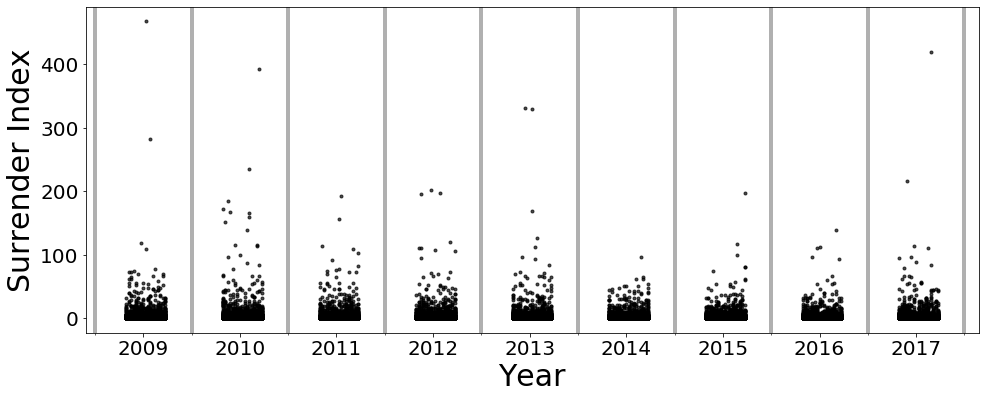

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import seaborn as sb
blue,red,amber=sb.xkcd_palette(['windows blue','pale red','amber'])

fig=plt.figure(figsize=(16,6))
subplt=plt.subplot(111)

subplt.plot(df['Year'] + (df['Week'] - 8)/40, df['surr_index'], 'ko', ms=3,alpha=0.7)

subplt.set_xlabel('Year', fontsize=30)
subplt.set_ylabel('Surrender Index', fontsize=30)

subplt.set_xticks(np.arange(2009,2018,1))
plt.tick_params(which='both',labelsize=20)
plt.ticklabel_format(useOffset=False)

subplt.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(2008,2018,1)+0.5))

plt.grid(b=False,which='major', axis='x')
plt.grid(b=True,which='minor', axis='x', lw=4)

Text(0.5, 0, 'Field Position')

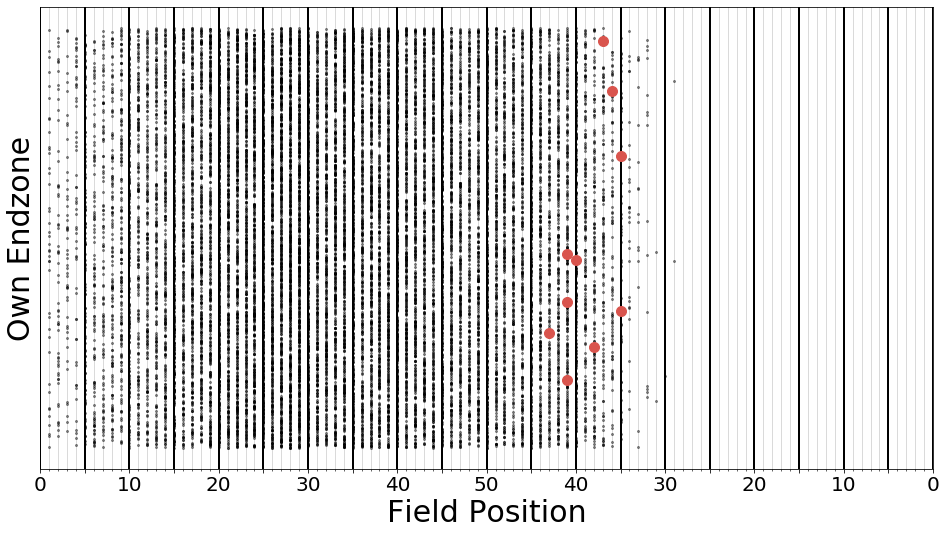

In [55]:
fig=plt.figure(figsize=(16,8.5))
subplt=plt.subplot(111)

ys=np.random.rand(len(df))
subplt.plot(df['YrdLine'], ys, 'ko', ms=2,alpha=0.4)
subplt.plot(df['YrdLine'].iloc[0:10], ys[0:10],
            linestyle='None', marker='o', color=red, ms=10)


subplt.set_xlim(0,100)
subplt.set_xticks(np.arange(0,101,5))
subplt.set_xticklabels([0,'',10,'',20,'',30,'',40,'',50,
                        '',40,'',30,'',20,'',10,'',0])
subplt.xaxis.set_minor_locator(ticker.MultipleLocator(1))

subplt.set_yticks([])
subplt.set_yticklabels([])


plt.tick_params(axis='both', labelsize=20)
subplt.grid(which='major', axis='x', color='k', lw=2)
subplt.grid(which='minor', axis='x', color='0.1',alpha=0.2)

subplt.set_ylabel('Own Endzone',fontsize=30)
subplt.set_xlabel('Field Position',fontsize=30)

In [42]:
np.arange(0,101,5)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

In [56]:
def live_callback(active, completed, diffs):
    for diff in diffs:
        print(diffs)
        for play in diff.plays:
            if 'punt' in play.desc.lower() and 'no play' not in play.desc.lower():
                print(play.desc)

In [57]:
nflgame.live.run(live_callback, active_interval=15, inactive_interval=15, stop=None)

KeyboardInterrupt: 

In [63]:
print(f"Q{play.data['qtr']}", play.data['time'])
print(results[0][0].desc)

Q5 11:21
(1:48) (Punt formation) D.Johnson punts 23 yards to GB 13, Center-A.Economos, downed by TB-N.Koutouvides.


In [8]:
play.playid

'139'

In [9]:
scores={}

In [11]:
play.drive.game.gamekey

'54467'

In [18]:
scores[play.drive.game.gamekey] = set(play)

TypeError: 'Play' object is not iterable

In [19]:
game = set()

In [20]:
game.add(play)

TypeError: unhashable type: 'Play'